## Varying Number of Centriods

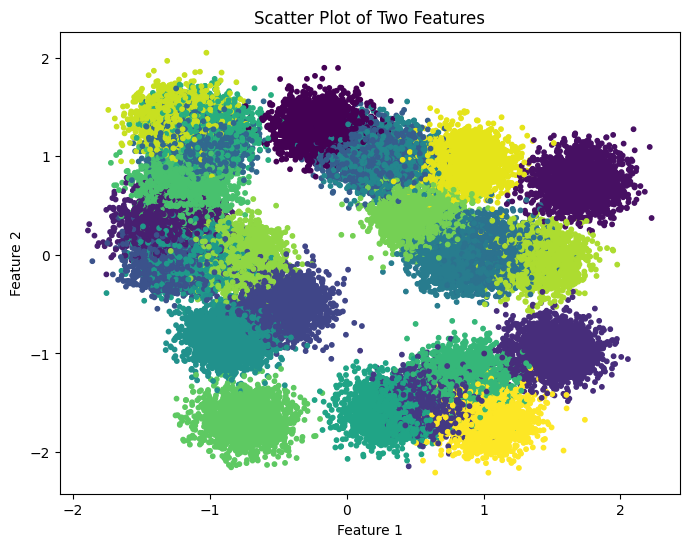

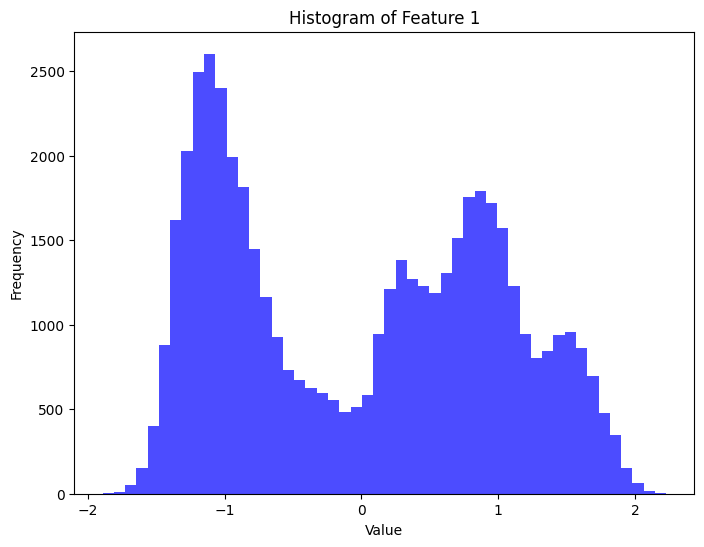

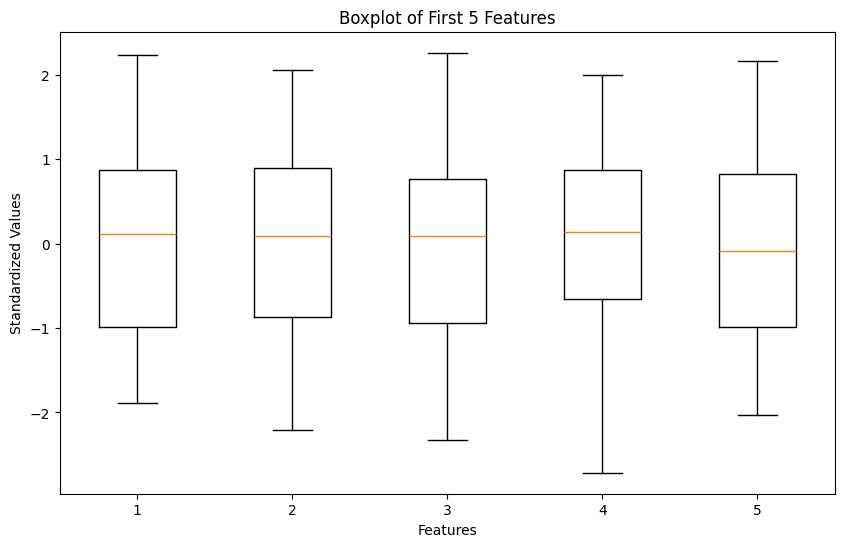

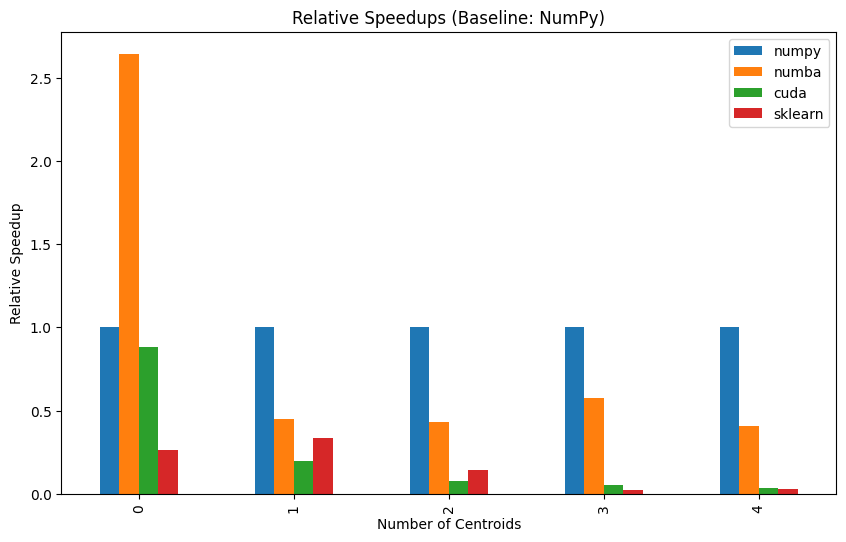

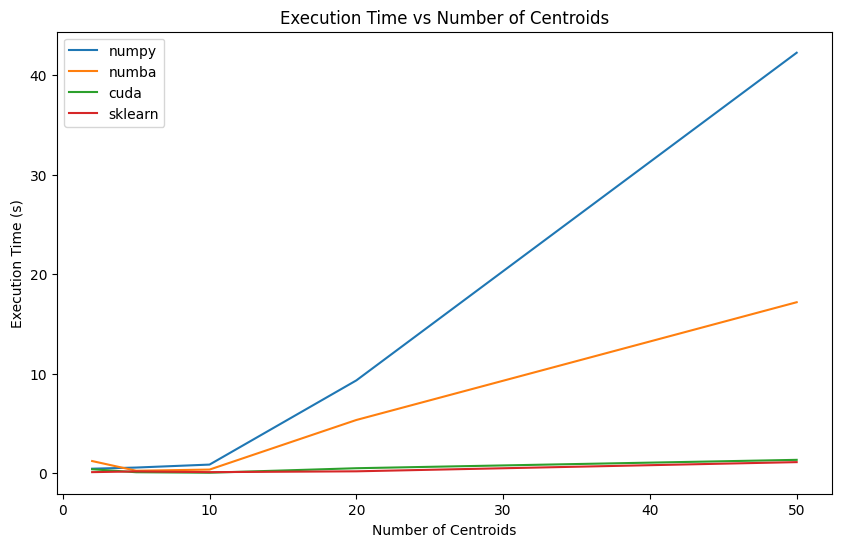

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit, cuda
import time
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Generate large synthetic dataset of blobs
n_samples = 50_000
n_features = 50
n_centers = 25
X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_centers, random_state=42)

# Preprocessing: Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Plot graphs for visualization
# Graph 1: Scatter plot of two features
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='viridis', s=10)
plt.title("Scatter Plot of Two Features")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# Graph 2: Histogram of a single feature
plt.figure(figsize=(8, 6))
plt.hist(X_scaled[:, 0], bins=50, color='blue', alpha=0.7)
plt.title("Histogram of Feature 1")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

# Graph 3: Boxplot of multiple features
plt.figure(figsize=(10, 6))
plt.boxplot(X_scaled[:, :5])
plt.title("Boxplot of First 5 Features")
plt.xlabel("Features")
plt.ylabel("Standardized Values")
plt.show()

# Define baseline K-Means implementation using NumPy
def kmeans_numpy(data, n_centroids, max_iter=100):
    np.random.seed(42)
    centroids = data[np.random.choice(data.shape[0], n_centroids, replace=False)]
    for _ in range(max_iter):
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        new_centroids = np.array([data[labels == i].mean(axis=0) if np.any(labels == i) else centroids[i] for i in range(n_centroids)])
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    return labels, centroids

# Accelerated K-Means using Numba (CPU)
@jit(nopython=True)
def kmeans_numba(data, n_centroids, max_iter=100):
    np.random.seed(42)
    centroids = data[np.random.choice(data.shape[0], n_centroids, replace=False)]
    for _ in range(max_iter):
        distances = np.zeros((data.shape[0], n_centroids))
        for i in range(data.shape[0]):
            for j in range(n_centroids):
                distances[i, j] = np.sum((data[i] - centroids[j]) ** 2)
        labels = np.zeros(data.shape[0], dtype=np.int32)
        for i in range(data.shape[0]):
            labels[i] = np.argmin(distances[i])
        new_centroids = np.zeros((n_centroids, data.shape[1]))
        counts = np.zeros(n_centroids)
        for i in range(data.shape[0]):
            new_centroids[labels[i]] += data[i]
            counts[labels[i]] += 1
        for j in range(n_centroids):
            if counts[j] > 0:
                new_centroids[j] /= counts[j]
            else:
                new_centroids[j] = centroids[j]
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids
    return labels, centroids

# Accelerated K-Means using CUDA (GPU)
@cuda.jit
def compute_distances(data, centroids, distances):
    i, j = cuda.grid(2)
    if i < data.shape[0] and j < centroids.shape[0]:
        diff = 0
        for k in range(data.shape[1]):
            diff += (data[i, k] - centroids[j, k]) ** 2
        distances[i, j] = diff

def kmeans_cuda(data, n_centroids, max_iter=100):
    np.random.seed(42)
    centroids = data[np.random.choice(data.shape[0], n_centroids, replace=False)]
    data_device = cuda.to_device(data)
    labels = np.zeros(data.shape[0], dtype=np.int32)
    labels_device = cuda.to_device(labels)
    centroids_device = cuda.to_device(centroids)
    distances = np.zeros((data.shape[0], n_centroids), dtype=np.float32)
    distances_device = cuda.to_device(distances)

    threads_per_block = (16, 16)
    blocks_per_grid_x = int(np.ceil(data.shape[0] / threads_per_block[0]))
    blocks_per_grid_y = int(np.ceil(n_centroids / threads_per_block[1]))
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    for _ in range(max_iter):
        compute_distances[blocks_per_grid, threads_per_block](data_device, centroids_device, distances_device)
        distances = distances_device.copy_to_host()
        labels = np.argmin(distances, axis=1)
        new_centroids = np.array([data[labels == i].mean(axis=0) if np.any(labels == i) else centroids[i] for i in range(n_centroids)])
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids
        centroids_device = cuda.to_device(centroids)

    return labels, centroids

# Measure execution times and relative speed-ups
methods = ['numpy', 'numba', 'cuda', 'sklearn']
time_results = []
n_centroids_list = [2, 5, 10, 20, 50]

for n_centroids in n_centroids_list:
    results = {}

    start = time.time()
    kmeans_numpy(X_scaled, n_centroids)
    results['numpy'] = time.time() - start

    start = time.time()
    kmeans_numba(X_scaled, n_centroids)
    results['numba'] = time.time() - start

    start = time.time()
    kmeans_cuda(X_scaled, n_centroids)
    results['cuda'] = time.time() - start

    start = time.time()
    KMeans(n_clusters=n_centroids, max_iter=100, random_state=42).fit(X_scaled)
    results['sklearn'] = time.time() - start

    time_results.append(results)

# Plot relative speed-ups
speedups = pd.DataFrame(time_results)
speedups = speedups.div(speedups['numpy'], axis=0)
speedups.plot(kind='bar', figsize=(10, 6))
plt.title("Relative Speedups (Baseline: NumPy)")
plt.xlabel("Number of Centroids")
plt.ylabel("Relative Speedup")
plt.legend(methods)
plt.show()

# Plot execution time vs number of centroids
plt.figure(figsize=(10, 6))
for method in methods:
    plt.plot(n_centroids_list, [t[method] for t in time_results], label=method)
plt.title("Execution Time vs Number of Centroids")
plt.xlabel("Number of Centroids")
plt.ylabel("Execution Time (s)")
plt.legend()
plt.show()


## Varying Number of sample points

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 126 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


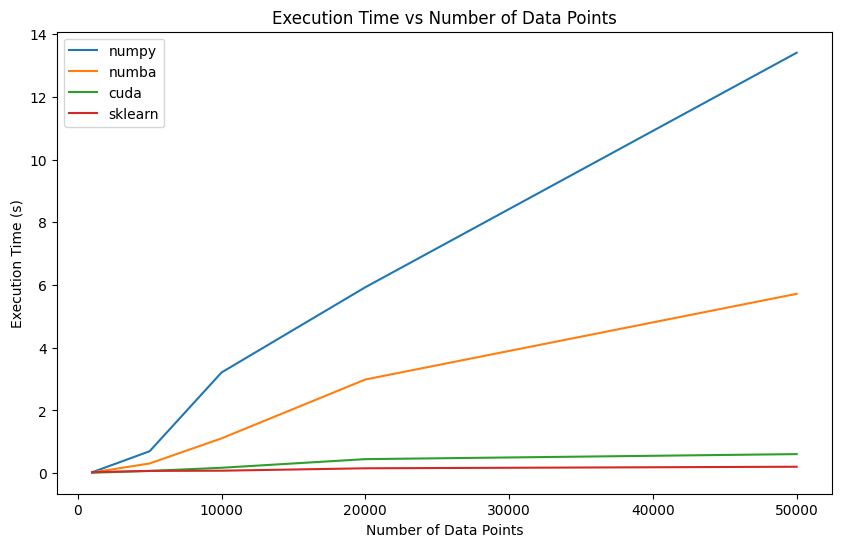

In [4]:
# Vary sample size
sample_sizes = [1000, 5000, 10000, 20000, 50000]
n_features = 50
n_centers = 25
time_results = []

for n_samples in sample_sizes:
    # Generate data
    X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_centers, random_state=42)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    results = {}

    # Time
    start = time.time()
    kmeans_numpy(X_scaled, n_centers)
    results['numpy'] = time.time() - start

    start = time.time()
    kmeans_numba(X_scaled, n_centers)
    results['numba'] = time.time() - start

    start = time.time()
    kmeans_cuda(X_scaled, n_centers)
    results['cuda'] = time.time() - start

    start = time.time()
    KMeans(n_clusters=n_centers, max_iter=100, random_state=42).fit(X_scaled)
    results['sklearn'] = time.time() - start

    time_results.append(results)

# Plot
methods = ['numpy', 'numba', 'cuda', 'sklearn']
plt.figure(figsize=(10, 6))
for method in methods:
    plt.plot(sample_sizes, [t[method] for t in time_results], label=method)
plt.title("Execution Time vs Number of Data Points")
plt.xlabel("Number of Data Points")
plt.ylabel("Execution Time (s)")
plt.legend()
plt.show()
